In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("benjaminawd/new-york-times-articles-comments-2020")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-york-times-articles-comments-2020


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import re
import string

# Load the data
articles_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv'
comments_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv'

articles = pd.read_csv(articles_path)

# Feature Selection
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df.loc[:, 'headline'] = df['headline'].fillna('').apply(clean_text)
df.loc[:, 'abstract'] = df['abstract'].fillna('').apply(clean_text)
# Feature Engineering
df.loc[:, 'headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df.loc[:, 'abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df.loc[:, 'interaction_term'] = df['word_count'] * df['headline_word_count']

# Encoding and Scaling
X = df.drop('n_comments', axis=1)
y = df['n_comments']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'headline_word_count', 'abstract_word_count', 'interaction_term']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for consistent processing
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')


Train data shape: (13429, 44)
Test data shape: (3358, 44)


Mean Squared Error: 163046.66
R² Score: 0.33


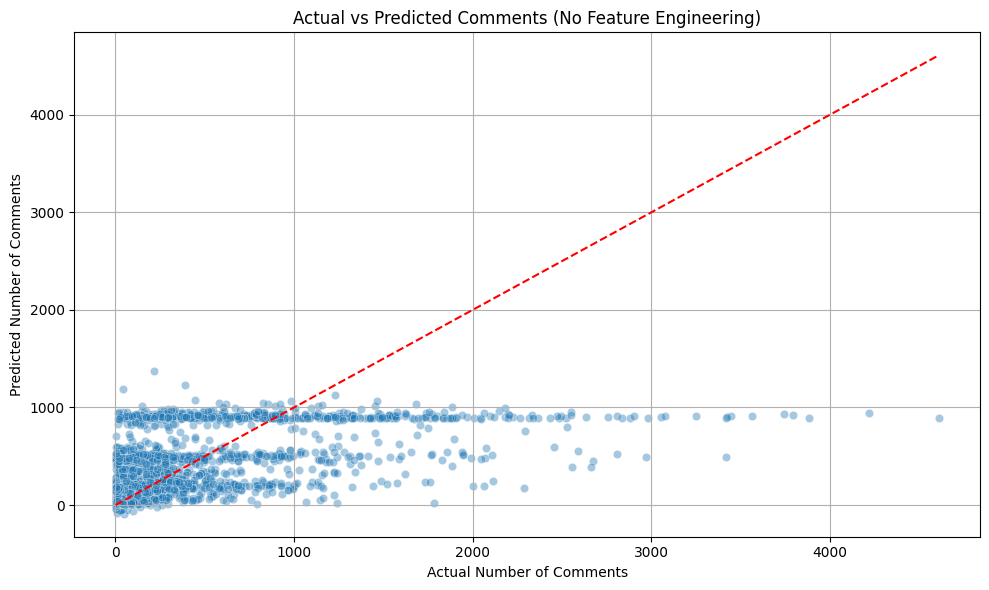

In [5]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

articles = pd.read_csv(articles_path)

# Select only the raw features
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Clean the text columns (optional but safe)
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df['headline'] = df['headline'].fillna('').apply(clean_text)
df['abstract'] = df['abstract'].fillna('').apply(clean_text)

# Drop NA target values
df = df.dropna(subset=['n_comments'])

# Prepare input and target
X = df[['section', 'word_count']]
y = df['n_comments']

# Define preprocessing (no feature engineering)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Transform features
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Number of Comments')
plt.ylabel('Predicted Number of Comments')
plt.title('Actual vs Predicted Comments (No Feature Engineering)')
plt.grid(True)
plt.tight_layout()
plt.show()


Mean Squared Error: 156173.37
R² Score: 0.36


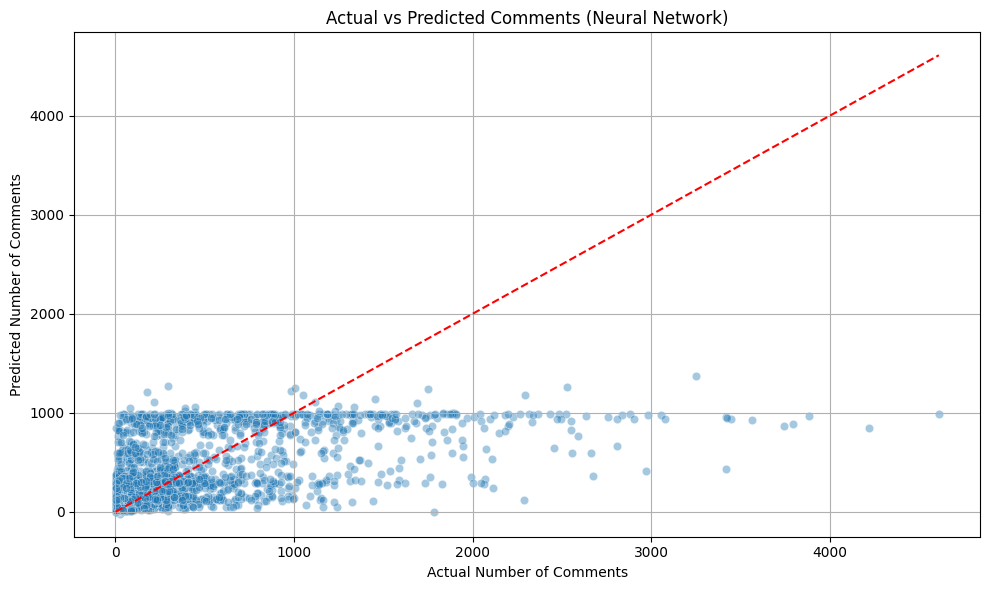

In [6]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor

# Load the data
articles_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv'
articles = pd.read_csv(articles_path)

# Select only the raw features
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Clean the text columns (optional but safe)
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df['headline'] = df['headline'].fillna('').apply(clean_text)
df['abstract'] = df['abstract'].fillna('').apply(clean_text)

# Drop NA target values
df = df.dropna(subset=['n_comments'])

# Prepare input and target
X = df[['section', 'word_count']]
y = df['n_comments']

# Define preprocessing (no feature engineering)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Transform features
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Define and train the neural network model (MLPRegressor)
model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Number of Comments')
plt.ylabel('Predicted Number of Comments')
plt.title('Actual vs Predicted Comments (Neural Network)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import re
import string

# Load the data


articles = pd.read_csv(articles_path)

# Feature Selection
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df.loc[:, 'headline'] = df['headline'].fillna('').apply(clean_text)
df.loc[:, 'abstract'] = df['abstract'].fillna('').apply(clean_text)
# Feature Engineering
df.loc[:, 'headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df.loc[:, 'abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df.loc[:, 'interaction_term'] = df['word_count'] * df['headline_word_count']

# Encoding and Scaling
X = df.drop('n_comments', axis=1)
y = df['n_comments']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'headline_word_count', 'abstract_word_count', 'interaction_term']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for consistent processing
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')


Train data shape: (13429, 44)
Test data shape: (3358, 44)


Mean Squared Error: 162738.36
R² Score: 0.34


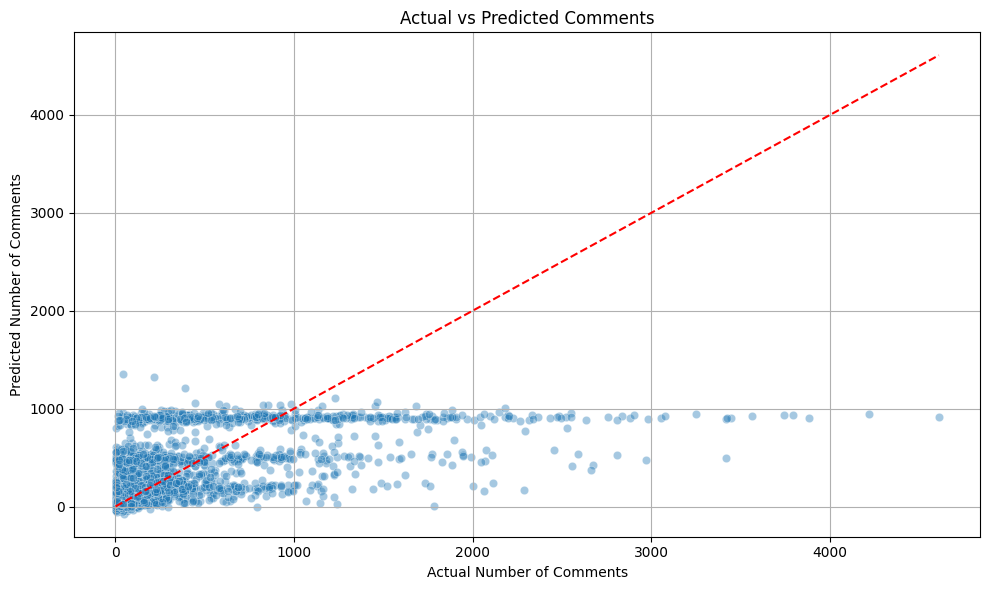

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


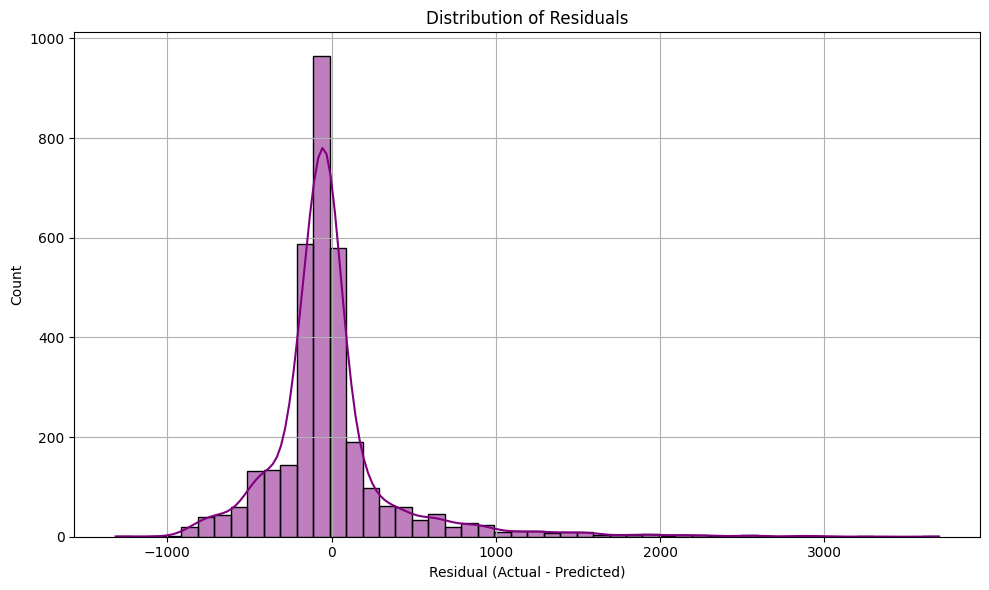

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 2. Make predictions
y_pred = model.predict(X_test)

# 3. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# 4. Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Number of Comments')
plt.ylabel('Predicted Number of Comments')
plt.title('Actual vs Predicted Comments')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import re
import string

# Load the data
articles_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv'
comments_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv'

articles = pd.read_csv(articles_path)

# Feature Selection
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df.loc[:, 'headline'] = df['headline'].fillna('').apply(clean_text)
df.loc[:, 'abstract'] = df['abstract'].fillna('').apply(clean_text)
# Feature Engineering
df.loc[:, 'headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df.loc[:, 'abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df.loc[:, 'interaction_term'] = df['word_count'] * df['headline_word_count']

# Encoding and Scaling
X = df.drop('n_comments', axis=1)
y = df['n_comments']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'headline_word_count', 'abstract_word_count', 'interaction_term']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for consistent processing
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')


Train data shape: (13429, 44)
Test data shape: (3358, 44)


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score ,accuracy_score
import re
import string

In [13]:
from sklearn.ensemble import RandomForestRegressor

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=3000, learning_rate_init=0.001, activation='relu', solver='adam', alpha=0.001, random_state=42)
nn_model.fit(X_train, y_train)
nn_preds = nn_model.predict(X_test)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f'{model_name} Results:')
    print(f'RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.4f}')
    print(f'R^2: {r2_score(y_true, y_pred):.4f}')
    print(f'Accuracy: {accuracy_score(y_true.round(), y_pred.round()):.4f}\n')

evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, nn_preds, "Neural Network")
evaluate_model(y_test, rf_preds, "Random Forest")

Linear Regression Results:
RMSE: 403.4084
MAE: 231.0930
R^2: 0.3361
Accuracy: 0.0027

Neural Network Results:
RMSE: 390.0325
MAE: 219.4842
R^2: 0.3794
Accuracy: 0.0027

Random Forest Results:
RMSE: 420.1145
MAE: 233.2208
R^2: 0.2800
Accuracy: 0.0045



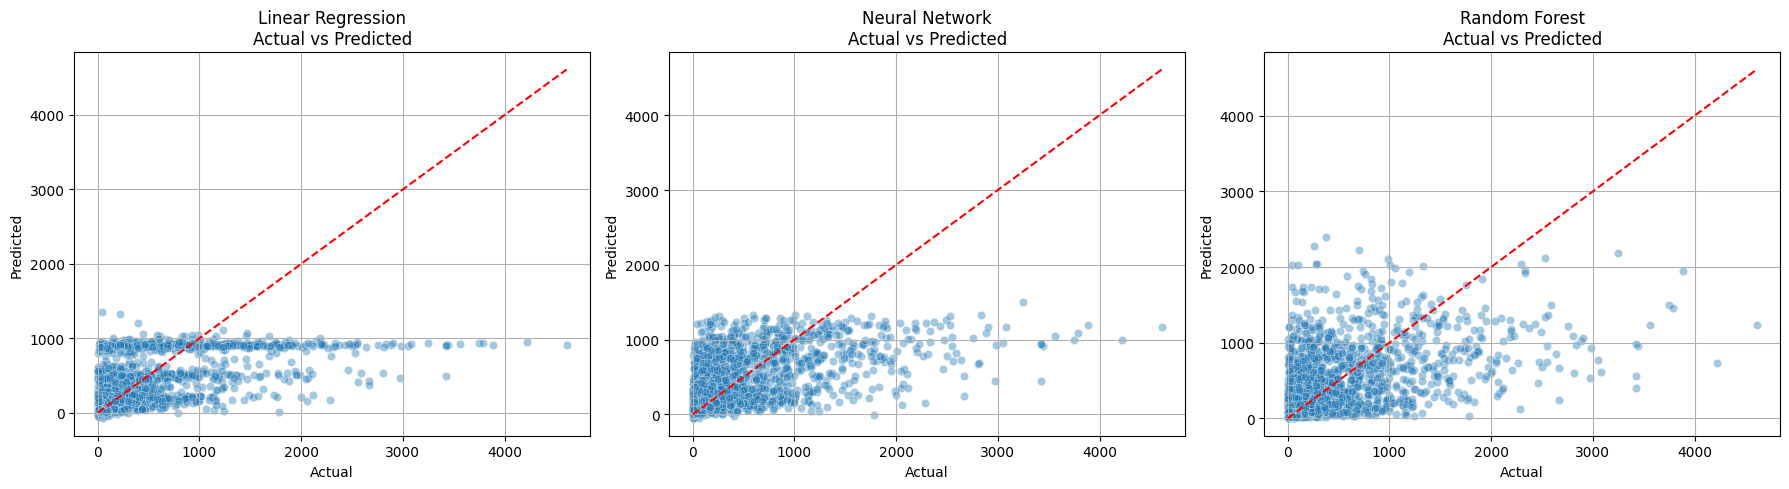

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Actual vs Predicted for all models
plt.figure(figsize=(18, 5))

models = {
    "Linear Regression": lr_preds,
    "Neural Network": nn_preds,
    "Random Forest": rf_preds
}

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name}\nActual vs Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()


Log

In [16]:
import numpy as np

# Log-transform the target
y = np.log1p(df['n_comments'])

# Keep the rest of the pipeline the same
# Use the correctly transformed test set
X_test_transformed = pipeline.transform(X_test)

# Now use it to predict
lr_preds = np.expm1(lr_model.predict(X_test_transformed))
nn_preds = np.expm1(nn_model.predict(X_test_transformed))
rf_preds = np.expm1(rf_model.predict(X_test_transformed))




# Also inverse-transform actual test values for evaluation
y_test_actual = np.expm1(y_test)


/tmp/ipykernel_31/2751104924.py:12: RuntimeWarning: invalid value encountered in expm1
  nn_preds = np.expm1(nn_model.predict(X_test_transformed))
/tmp/ipykernel_31/2751104924.py:13: RuntimeWarning: invalid value encountered in expm1
  rf_preds = np.expm1(rf_model.predict(X_test_transformed))


In [17]:
def evaluate_model(y_true, y_pred, model_name):
    print(f'{model_name} Results:')
    print(f'RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.4f}')
    print(f'R^2: {r2_score(y_true, y_pred):.4f}\n')


In [19]:
# Properly transformed data
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)



In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import numpy as np

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_transformed, y_train)
lr_preds = lr_model.predict(X_test_transformed)

# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=3000, learning_rate_init=0.001, activation='relu', solver='adam', alpha=0.001, random_state=42)
nn_model.fit(X_train_transformed, y_train)
nn_preds = nn_model.predict(X_test_transformed)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_transformed, y_train)
rf_preds = rf_model.predict(X_test_transformed)

# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f'{model_name} Results:')
    print(f'RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.4f}')
    print(f'R^2: {r2_score(y_true, y_pred):.4f}')
    print(f'Accuracy: {accuracy_score(y_true.round(), y_pred.round()):.4f}\n')

evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, nn_preds, "Neural Network")
evaluate_model(y_test, rf_preds, "Random Forest")

Linear Regression Results:
RMSE: 1.3535
MAE: 1.0824
R^2: 0.4183
Accuracy: 0.2638

Neural Network Results:
RMSE: 1.2905
MAE: 1.0109
R^2: 0.4712
Accuracy: 0.3091

Random Forest Results:
RMSE: 1.3426
MAE: 1.0497
R^2: 0.4277
Accuracy: 0.3038



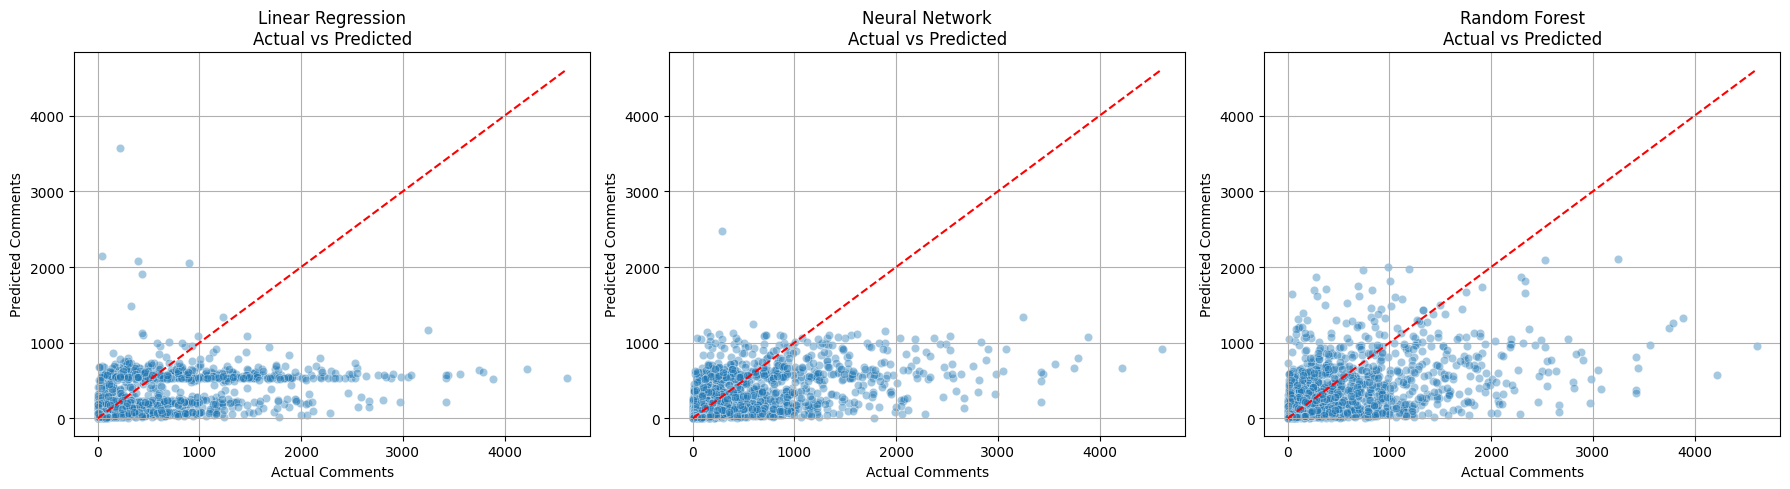

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Inverse-transform predictions and y_test
y_test_actual = np.expm1(y_test)
lr_preds_actual = np.expm1(lr_preds)
nn_preds_actual = np.expm1(nn_preds)
rf_preds_actual = np.expm1(rf_preds)

# Dictionary of model predictions
models = {
    "Linear Regression": lr_preds_actual,
    "Neural Network": nn_preds_actual,
    "Random Forest": rf_preds_actual
}

# Plotting
plt.figure(figsize=(18, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test_actual, y=preds, alpha=0.4)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], '--', color='red')
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.title(f"{name}\nActual vs Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()


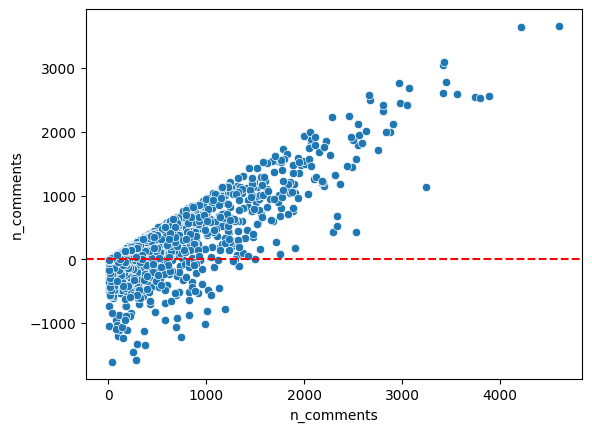

In [22]:
sns.scatterplot(x=y_test_actual, y=(y_test_actual - preds))
plt.axhline(0, color='red', linestyle='--')


In [ ]:
Points close to the red line → accurate predictions.

Points below the line → overpredictions (model predicted higher than actual).

Points above the line → underpredictions.



In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# TF-IDF Vectorizers
tfidf_headline = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_abstract = TfidfVectorizer(max_features=100, stop_words='english')

# Transform headline and abstract
headline_tfidf = tfidf_headline.fit_transform(df['headline'])
abstract_tfidf = tfidf_abstract.fit_transform(df['abstract'])


In [24]:
from textblob import TextBlob

df['headline_sentiment'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['abstract_sentiment'] = df['abstract'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [2]:
!pip install -U spacy
!pip install -U "spacy[transformers]"
!python -m spacy download en_core_web_trf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 59.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 77.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 100.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account a

In [1]:
import spacy

# Load the transformer-based NER model
nlp = spacy.load("en_core_web_trf")


/usr/local/lib/python3.11/dist-packages/thinc/shims/pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=dev

In [3]:
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from textblob import TextBlob
import spacy
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
articles = pd.read_csv('/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv')
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# --- Text Cleaning ---
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df['headline'] = df['headline'].fillna('').apply(clean_text)
df['abstract'] = df['abstract'].fillna('').apply(clean_text)

# --- Word Counts ---
df['headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df['interaction_term'] = df['word_count'] * df['headline_word_count']

# --- Sentiment ---
df['headline_sentiment'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['abstract_sentiment'] = df['abstract'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [5]:
from tqdm import tqdm
tqdm.pandas()

# Batch processing with nlp.pipe
head_docs = list(tqdm(nlp.pipe(df['headline'].fillna(''), batch_size=64), total=len(df)))
abs_docs = list(tqdm(nlp.pipe(df['abstract'].fillna(''), batch_size=64), total=len(df)))

# Entity count function
def count_entities(doc, label):
    return sum(1 for ent in doc.ents if ent.label_ == label)

# Add entity count features
for label in ['PERSON', 'ORG', 'DATE']:
    df[f'headline_{label.lower()}_count'] = [count_entities(doc, label) for doc in head_docs]
    df[f'abstract_{label.lower()}_count'] = [count_entities(doc, label) for doc in abs_docs]


100%|██████████| 16787/16787 [13:27<00:00, 20.79it/s]


In [6]:
tfidf_headline = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_abstract = TfidfVectorizer(max_features=100, stop_words='english')
headline_tfidf = tfidf_headline.fit_transform(df['headline'])
abstract_tfidf = tfidf_abstract.fit_transform(df['abstract'])

In [7]:

# --- Numerical Features ---
numerical_features = df[['word_count', 'headline_word_count', 'abstract_word_count',
                         'interaction_term', 'headline_sentiment', 'abstract_sentiment',
                         'headline_person_count', 'abstract_person_count',
                         'headline_org_count', 'abstract_org_count',
                         'headline_date_count', 'abstract_date_count']]

# --- Categorical (Section) ---
section_encoded = pd.get_dummies(df['section'], prefix='section')

# --- Combine All Features ---
X_combined = hstack([headline_tfidf, abstract_tfidf, 
                     numerical_features.values, section_encoded.values])

# --- Target ---
y = np.log1p(df['n_comments'])

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# --- XGBoost Regressor ---
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=6,
                         subsample=0.8, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# --- Predictions ---
y_pred_log = xgb_model.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# --- Metrics ---
print(f"RMSE: {mean_squared_error(y_test_actual, y_pred_actual, squared=False):.4f}")
print(f"MAE: {mean_absolute_error(y_test_actual, y_pred_actual):.4f}")
print(f"R²: {r2_score(y_test_actual, y_pred_actual):.4f}")

RMSE: 404.4222
MAE: 190.1966
R²: 0.3327


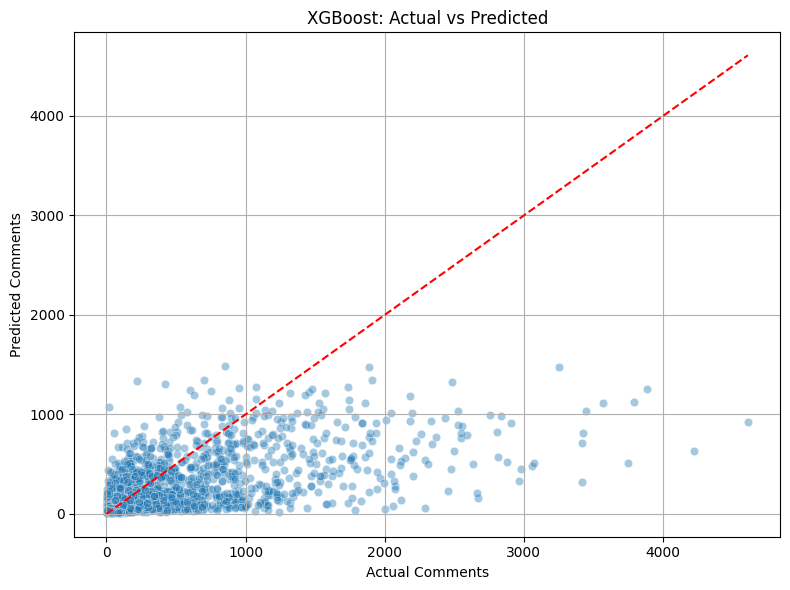

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


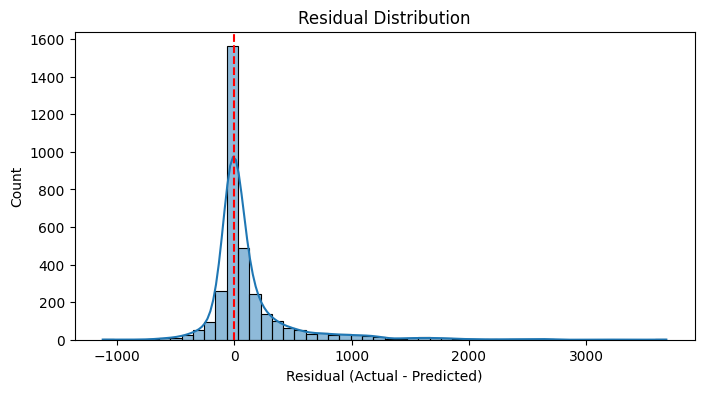

In [8]:
# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.4)
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')
plt.xlabel("Actual Comments")
plt.ylabel("Predicted Comments")
plt.title("XGBoost: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


In [2]:
!pip install textblob nltk xgboost

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



=== LINEAR REGRESSION ===
Linear Regression Results:
RMSE: 424.6775
MAE: 202.8179
R²: 0.2642


=== NEURAL NETWORK ===
Neural Network Results:
RMSE: 442.3260
MAE: 204.6322
R²: 0.2018


=== RANDOM FOREST ===
Random Forest Results:
RMSE: 395.7045
MAE: 186.2609
R²: 0.3612


=== XGBOOST ===
XGBoost Results:
RMSE: 410.3560
MAE: 193.4624
R²: 0.3130



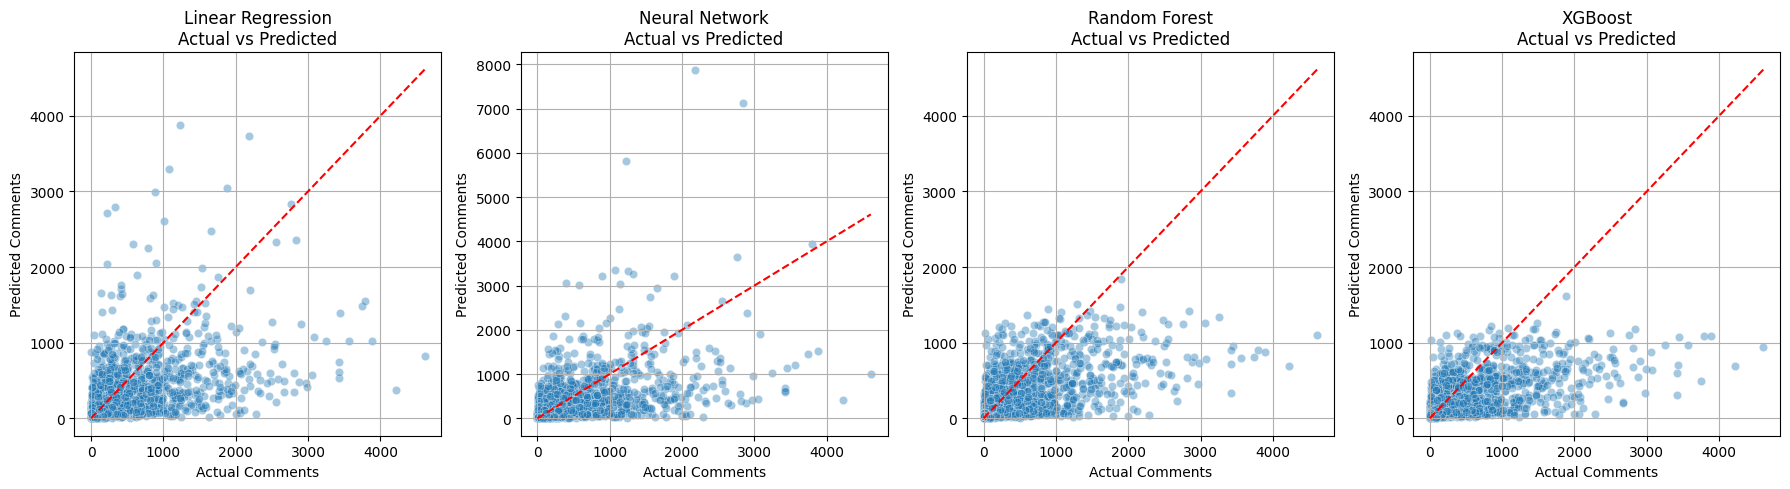


Best Random Forest Parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [3]:
# Install required packages (run once)
# !pip install textblob nltk xgboost

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLP resources
nltk.download('wordnet')
nltk.download('punkt')

# Load data
articles_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv'
articles = pd.read_csv(articles_path)

# Feature selection
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments', 'pub_date']
df = articles[selected_features].copy()

# Enhanced text preprocessing with lemmatization
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

df['headline'] = df['headline'].fillna('').apply(clean_text)
df['abstract'] = df['abstract'].fillna('').apply(clean_text)

# Feature engineering
df['headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df['interaction_term'] = df['word_count'] * df['headline_word_count']
df['headline_sentiment'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['abstract_sentiment'] = df['abstract'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['publication_day'] = pd.to_datetime(df['pub_date']).dt.dayofweek

# Prepare data
X = df.drop(['n_comments', 'pub_date'], axis=1)
y = np.log1p(df['n_comments'])  # Log-transform target

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [
            'word_count', 
            'headline_word_count', 
            'abstract_word_count', 
            'interaction_term',
            'headline_sentiment',
            'abstract_sentiment'
        ]),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['section', 'publication_day']),
        ('tfidf_headline', TfidfVectorizer(max_features=500), 'headline'),
        ('tfidf_abstract', TfidfVectorizer(max_features=500), 'abstract')
    ],
    remainder='drop'
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create processing pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Transform data
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=2000,
        learning_rate_init=0.001,
        early_stopping=True,
        random_state=42
    ),
    "Random Forest": GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid={
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5]
        },
        cv=3
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train_transformed, y_train)
    
    # Make predictions
    preds = model.predict(X_test_transformed)
    
    # Store results
    results[name] = {
        'model': model,
        'predictions': preds
    }

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f'{model_name} Results:')
    print(f'RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.4f}')
    print(f'R²: {r2_score(y_true, y_pred):.4f}\n')

# Evaluate all models
y_test_actual = np.expm1(y_test)  # Convert back from log scale

for name, data in results.items():
    preds = np.expm1(data['predictions'])
    print(f'\n{"="*40}')
    print(f'=== {name.upper()} ===')
    evaluate_model(y_test_actual, preds, name)

# Visualization
plt.figure(figsize=(18, 5))
for i, (name, data) in enumerate(results.items(), 1):
    plt.subplot(1, 4, i)
    preds = np.expm1(data['predictions'])
    sns.scatterplot(x=y_test_actual, y=preds, alpha=0.4)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], '--', color='red')
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.title(f"{name}\nActual vs Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Show best parameters for Random Forest
if 'Random Forest' in results:
    print("\nBest Random Forest Parameters:")
    print(results['Random Forest']['model'].best_params_)

Linear Regression Cross-Val R²: 0.4072
Random Forest Cross-Val R²: 0.4320
XGBoost Cross-Val R²: 0.4508

Final Test Results:

Linear Regression:
RMSE: 443.63
MAE: 211.49
R²: 0.1971

Random Forest:
RMSE: 422.74
MAE: 205.46
R²: 0.2709

XGBoost:
RMSE: 419.14
MAE: 200.52
R²: 0.2833


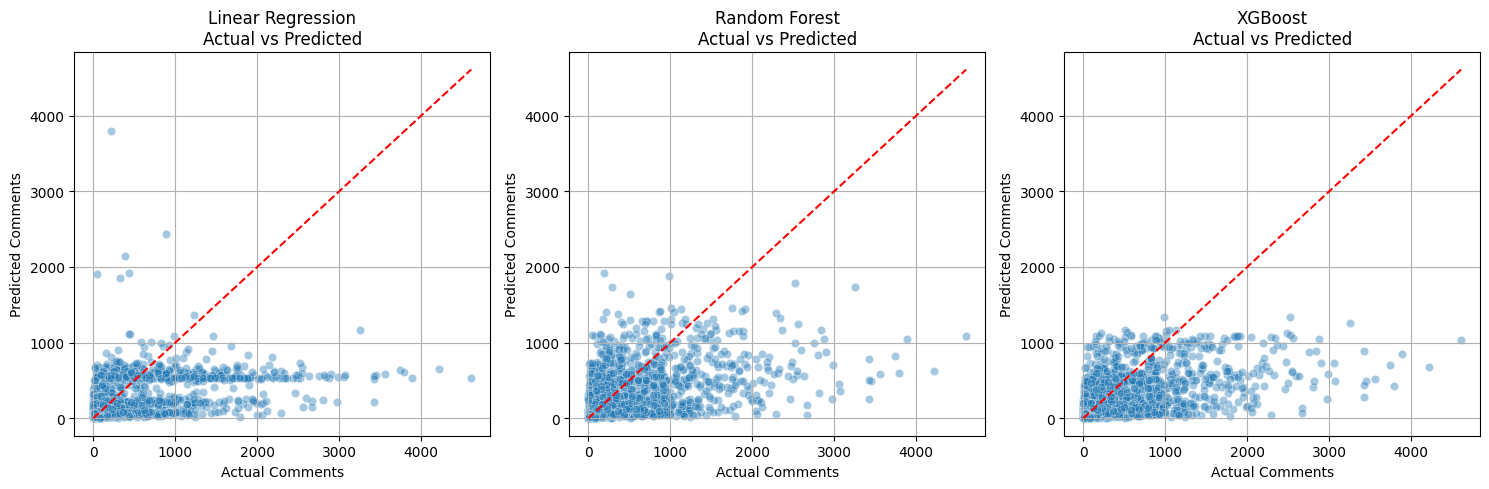

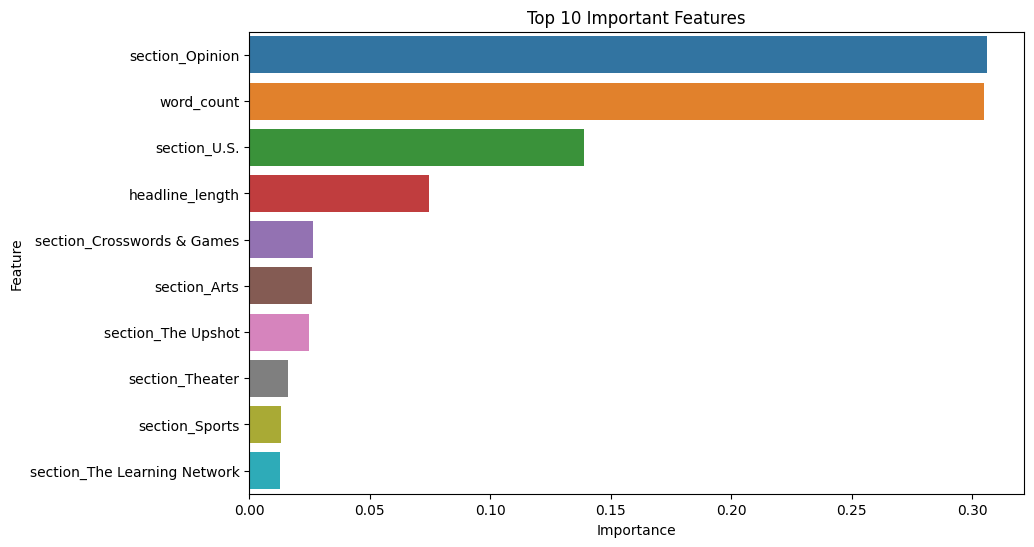

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and prepare data
articles = pd.read_csv('/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv')

# Simplified feature selection
selected_features = ['section', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Basic text-based feature engineering
df['headline'] = articles['headline'].fillna('').str.lower().str.replace(r'[^\w\s]', '', regex=True)
df['headline_length'] = df['headline'].apply(lambda x: len(x.split()))

# Target transformation
df['n_comments'] = np.log1p(df['n_comments'])  # Log-transform target

# Remove rows with missing values
df = df.dropna()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'headline_length']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

# Train-test split
X = df.drop('n_comments', axis=1)
y = df['n_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model setup with optimized parameters
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        random_state=42
    )
}

# Training and evaluation
results = {}
for name, model in models.items():
    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Cross-validation
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='r2')
    print(f"{name} Cross-Val R²: {np.mean(cv_scores):.4f}")
    
    # Final training
    pipe.fit(X_train, y_train)
    
    # Predictions
    preds = pipe.predict(X_test)
    results[name] = preds

# Inverse transformations for evaluation
def inverse_transform(y):
    return np.expm1(y)

# Evaluate models
print("\nFinal Test Results:")
for name, preds in results.items():
    y_true = inverse_transform(y_test)
    y_pred = inverse_transform(preds)
    
    print(f"\n{name}:")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")

# Visualization
plt.figure(figsize=(15, 5))
for i, (name, preds) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    y_pred_actual = inverse_transform(preds)
    sns.scatterplot(x=y_true, y=y_pred_actual, alpha=0.4)
    plt.plot([0, y_true.max()], [0, y_true.max()], '--r')
    plt.title(f"{name}\nActual vs Predicted")
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Feature importance analysis
rf_model = models['Random Forest'].fit(preprocessor.fit_transform(X_train), y_train)
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['section'])
feature_names = np.concatenate([['word_count', 'headline_length'], feature_names])

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title("Top 10 Important Features")
plt.show()

Neural Network CV R²: 0.4676
XGBoost CV R²: 0.4929
Random Forest CV R²: 0.4743

Neural Network Results:
RMSE: 378.74
MAE: 191.02
R²: 0.3256

XGBoost Results:
RMSE: 378.82
MAE: 187.51
R²: 0.3254

Random Forest Results:
RMSE: 373.44
MAE: 188.09
R²: 0.3444


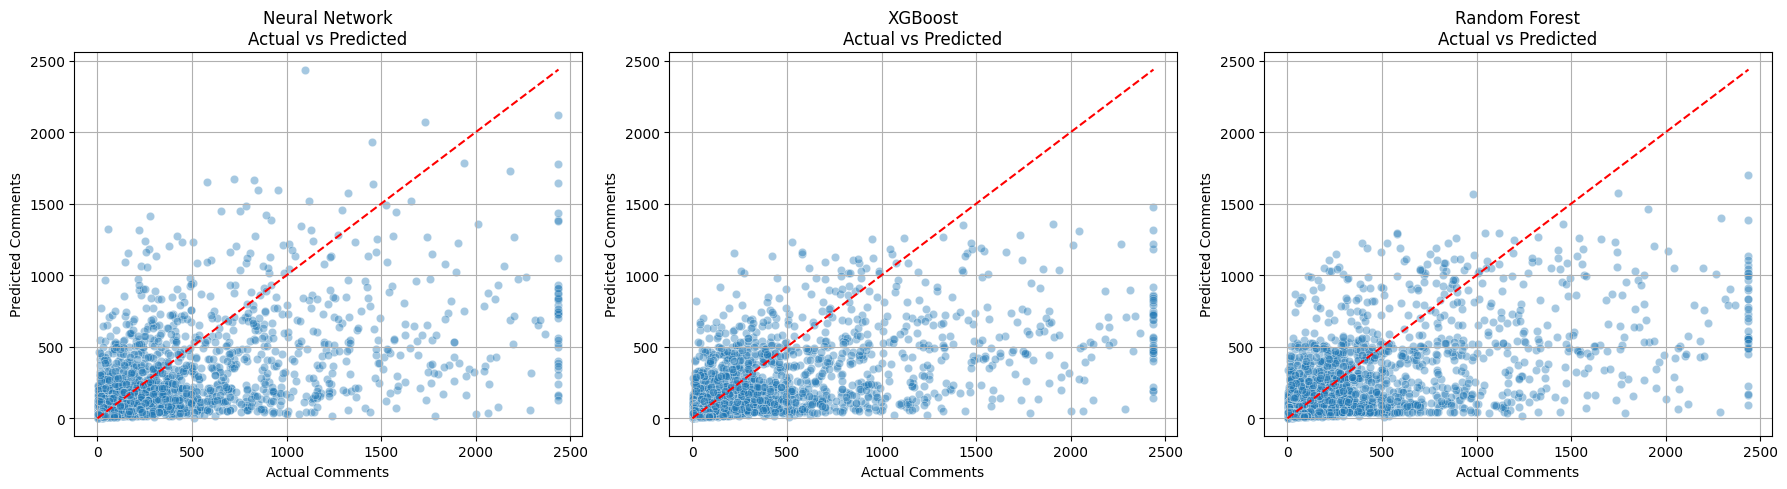

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

# Load data
articles = pd.read_csv('/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv')

# Feature selection and preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

selected_features = ['headline', 'section', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Enhanced text preprocessing
df['headline'] = df['headline'].fillna('').apply(clean_text)
df['headline_length'] = df['headline'].apply(lambda x: len(x.split()))
df['headline_sentiment'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Target transformation with outlier handling
comment_cap = df['n_comments'].quantile(0.99)
df['n_comments'] = df['n_comments'].clip(upper=comment_cap)
y = np.log1p(df['n_comments'])  # Log-transform after capping

# Feature engineering
X = df.drop('n_comments', axis=1)

# Improved preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), ['word_count', 'headline_length', 'headline_sentiment']),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['section']),
    ('tfidf', TfidfVectorizer(max_features=100), 'headline')
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models with optimized parameters
models = {
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        early_stopping=True,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
}

# Training and evaluation
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name] = preds

    # Cross-validation
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='r2')
    print(f"{name} CV R²: {np.mean(cv_scores):.4f}")

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    y_true_actual = np.expm1(y_true)
    y_pred_actual = np.expm1(y_pred)
    y_pred_actual = np.clip(y_pred_actual, 0, comment_cap)  # Clip predictions
    
    print(f"\n{model_name} Results:")
    print(f"RMSE: {mean_squared_error(y_true_actual, y_pred_actual, squared=False):.2f}")
    print(f"MAE: {mean_absolute_error(y_true_actual, y_pred_actual):.2f}")
    print(f"R²: {r2_score(y_true_actual, y_pred_actual):.4f}")

# Evaluate models
for name, preds in results.items():
    evaluate_model(y_test, preds, name)

# Visualization
plt.figure(figsize=(18, 5))
for i, (name, preds) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    y_true_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(preds)
    y_pred_actual = np.clip(y_pred_actual, 0, comment_cap)
    
    sns.scatterplot(x=y_true_actual, y=y_pred_actual, alpha=0.4)
    plt.plot([0, comment_cap], [0, comment_cap], '--r')
    plt.title(f"{name}\nActual vs Predicted")
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

# Load and prepare data
articles = pd.read_csv('/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv')

# Feature selection
df = articles[['headline', 'section', 'word_count', 'n_comments']].copy()

# 1. TARGET PROCESSING
comment_cap = df['n_comments'].quantile(0.95)  # Slightly tighter cap
df['n_comments'] = df['n_comments'].clip(upper=comment_cap)
y = np.log1p(df['n_comments'])

# 2. SIMPLIFIED FEATURE ENGINEERING
df['headline_len'] = df['headline'].str.len()
df['is_weekend'] = pd.to_datetime(articles['pub_date']).dt.weekday >= 5

# 3. OPTIMIZED PREPROCESSING
preprocessor = ColumnTransformer([
    ('text', CountVectorizer(max_features=50, stop_words='english'), 'headline'),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['section']),
    ('num', PowerTransformer(), ['word_count', 'headline_len'])
])

# 4. MODEL-SPECIFIC PIPELINES
models = {
    "NeuralNet": Pipeline([
        ('pre', preprocessor),
        ('model', MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation='tanh',  # Better for regression
            solver='adam',
            early_stopping=True,
            random_state=42
        ))
    ]),
    "XGBoost": Pipeline([
        ('pre', preprocessor),
        ('model', XGBRegressor(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=4,  # Shallower to prevent overfitting
            subsample=0.7,
            random_state=42
        ))
    ])
}

# 5. FOCUSED TRAINING
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('n_comments', axis=1), 
    y, 
    test_size=0.2, 
    random_state=42
)

results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name] = preds
    
    # Cross-validated R²
    cv_r2 = cross_val_score(pipe, X_train, y_train, 
                          cv=3, scoring='r2').mean()
    print(f"{name} CV R²: {cv_r2:.4f}")

# 6. ROBUST EVALUATION
def evaluate(y_true_log, y_pred_log, name):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log).clip(0, comment_cap)
    
    print(f"\n{name} Results:")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

for name, preds in results.items():
    evaluate(y_test, preds, name)

NeuralNet CV R²: 0.4820
XGBoost CV R²: 0.4834

NeuralNet Results:
R²: 0.3884
RMSE: 288.85
MAE: 163.05

XGBoost Results:
R²: 0.3511
RMSE: 297.53
MAE: 165.44


Linear Regression Results:
RMSE: 1.3535
MAE: 1.0824
R^2: 0.4183
Accuracy: 0.2638

Neural Network Results:
RMSE: 1.2905
MAE: 1.0109
R^2: 0.4712
Accuracy: 0.3091

Random Forest Results:
RMSE: 1.3426
MAE: 1.0497
R^2: 0.4277
Accuracy: 0.3038

XGBoost Results:
RMSE: 1.2904
MAE: 1.0229
R^2: 0.4713
Accuracy: 0.2898



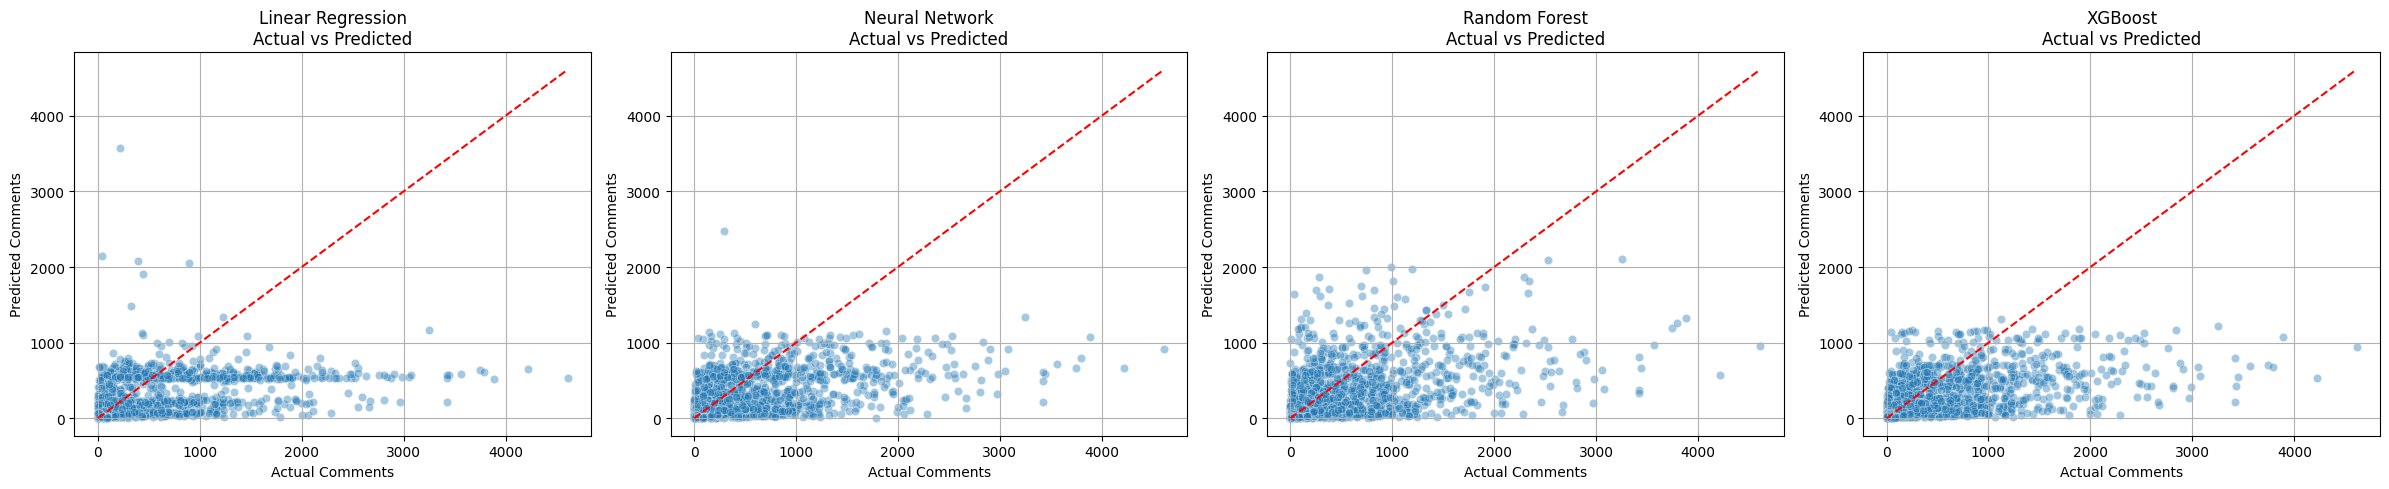

In [7]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# Load the data
articles_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv'
articles = pd.read_csv(articles_path)

# Feature Selection
selected_features = ['headline', 'section', 'abstract', 'word_count', 'n_comments']
df = articles[selected_features].copy()

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df.loc[:, 'headline'] = df['headline'].fillna('').apply(clean_text)
df.loc[:, 'abstract'] = df['abstract'].fillna('').apply(clean_text)

# Feature Engineering
df.loc[:, 'headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df.loc[:, 'abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df.loc[:, 'interaction_term'] = df['word_count'] * df['headline_word_count']

# Prepare data
X = df.drop('n_comments', axis=1)
y = df['n_comments']

# Log transform target
y = np.log1p(y)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['word_count', 'headline_word_count', 'abstract_word_count', 'interaction_term']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['section'])
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Train-Test Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform features
X_train = pipeline.fit_transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=3000, learning_rate_init=0.001,
                        activation='relu', solver='adam', alpha=0.001, random_state=42)
nn_model.fit(X_train, y_train)
nn_preds = nn_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f'{model_name} Results:')
    print(f'RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.4f}')
    print(f'R^2: {r2_score(y_true, y_pred):.4f}')
    print(f'Accuracy: {accuracy_score(y_true.round(), y_pred.round()):.4f}\n')

evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, nn_preds, "Neural Network")
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")

# Inverse transform for plots
y_test_actual = np.expm1(y_test)
lr_preds_actual = np.expm1(lr_preds)
nn_preds_actual = np.expm1(nn_preds)
rf_preds_actual = np.expm1(rf_preds)
xgb_preds_actual = np.expm1(xgb_preds)

models = {
    "Linear Regression": lr_preds_actual,
    "Neural Network": nn_preds_actual,
    "Random Forest": rf_preds_actual,
    "XGBoost": xgb_preds_actual
}

# Plot Actual vs Predicted
plt.figure(figsize=(24, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 4, i)
    sns.scatterplot(x=y_test_actual, y=preds, alpha=0.4)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], '--', color='red')
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.title(f"{name}\nActual vs Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBoost (Tuned) Results:
RMSE: 1.2840
MAE: 1.0133
R^2: 0.4765
Accuracy: 0.3011



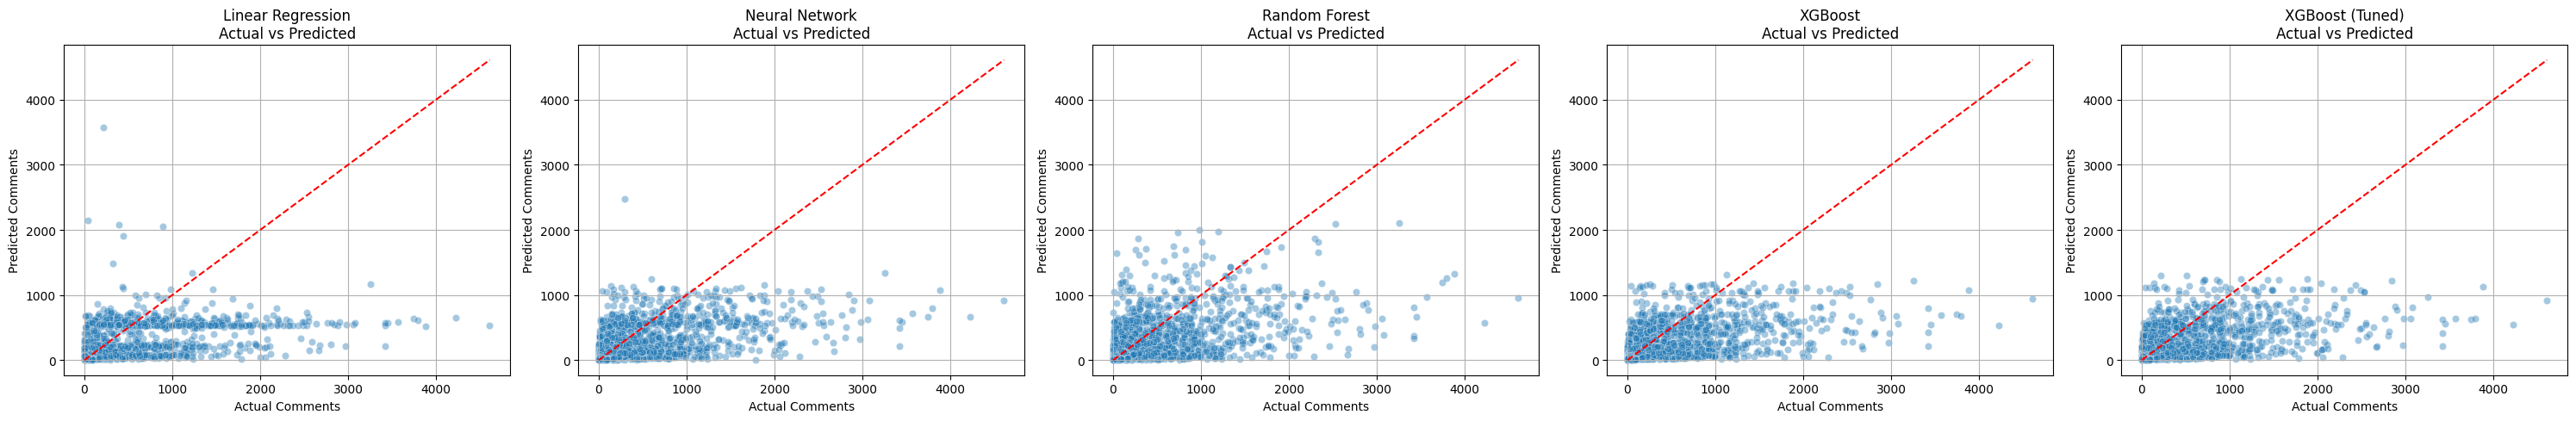

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define parameter space for tuning
xgb_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0.5, 1.0)
}

# XGBoost model
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

# RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_params,
    n_iter=30,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search on training data
xgb_search.fit(X_train, y_train)

# Best model from tuning
best_xgb = xgb_search.best_estimator_

# Predict using the best XGBoost model
xgb_preds = best_xgb.predict(X_test)

# Evaluation
evaluate_model(y_test, xgb_preds, "XGBoost (Tuned)")

# Inverse transform for plotting
xgb_preds_actual = np.expm1(xgb_preds)

# Add to plots
models["XGBoost (Tuned)"] = xgb_preds_actual

# Plot Updated Results
plt.figure(figsize=(30, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, len(models), i)
    sns.scatterplot(x=y_test_actual, y=preds, alpha=0.4)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], '--', color='red')
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.title(f"{name}\nActual vs Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS R

Neural Network (Tuned) Results:
RMSE: 1.2856
MAE: 1.0060
R^2: 0.4752
Accuracy: 0.3103



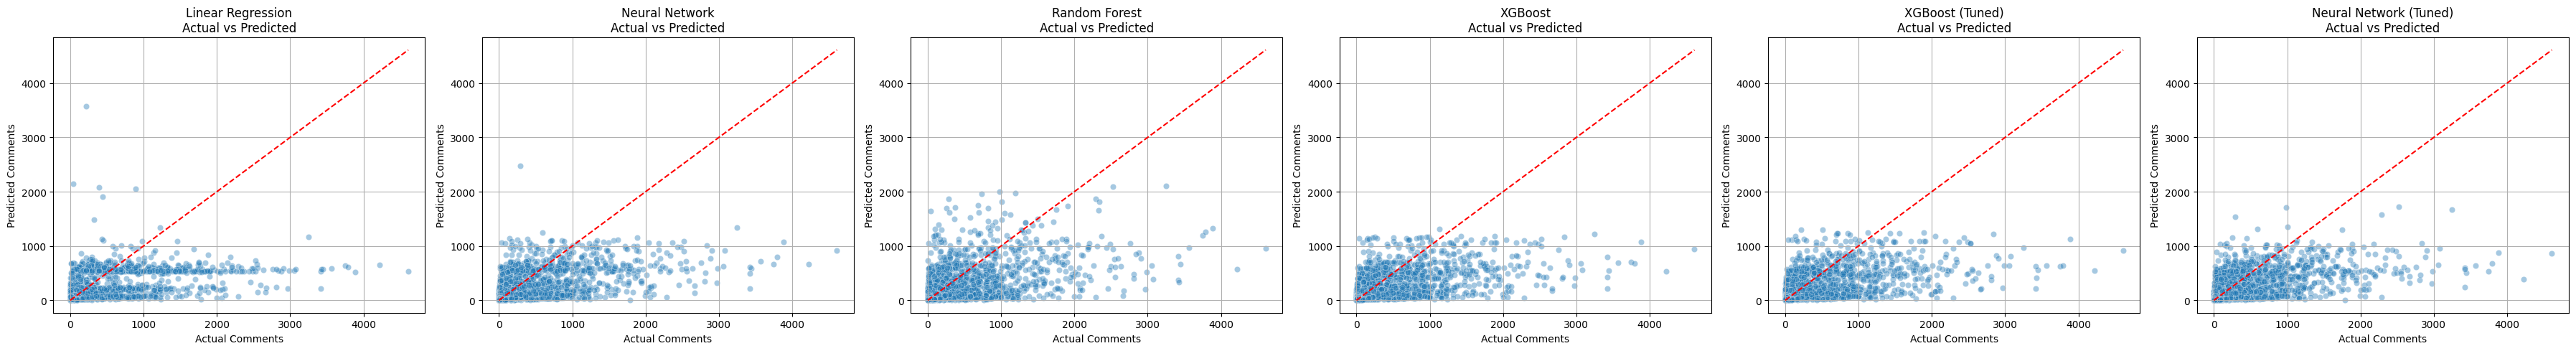

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Parameter grid for MLPRegressor
mlp_params = {
    'hidden_layer_sizes': [(32, 32), (64, 32), (64, 64), (128,)],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate_init': uniform(0.0005, 0.01),
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs']
}

# Create MLP model
mlp_model = MLPRegressor(max_iter=3000, random_state=42)

# RandomizedSearchCV for Neural Network
mlp_search = RandomizedSearchCV(
    mlp_model,
    param_distributions=mlp_params,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
mlp_search.fit(X_train, y_train)

# Best neural network
best_nn = mlp_search.best_estimator_

# Predict and evaluate
nn_preds = best_nn.predict(X_test)
evaluate_model(y_test, nn_preds, "Neural Network (Tuned)")

# Inverse-transform for plot
nn_preds_actual = np.expm1(nn_preds)
models["Neural Network (Tuned)"] = nn_preds_actual

# Final Plot with all models
plt.figure(figsize=(36, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, len(models), i)
    sns.scatterplot(x=y_test_actual, y=preds, alpha=0.4)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], '--', color='red')
    plt.xlabel("Actual Comments")
    plt.ylabel("Predicted Comments")
    plt.title(f"{name}\nActual vs Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()
